In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import pandas as pd
import pickle
import csv

In [ ]:
df = pd.read_csv('SPA_Massifs_19_02_2024.csv', header=0, delimiter=";")
df.rename(columns=lambda x: x.strip(), inplace=True)
print(df.columns)
print(type(df))

fit_to_coord = {}
fits = ["1st_fit", "2nd_fit", "3rd_fit"]
coord_sets = []
for fit in fits:
  # Define the filter conditions
  condition = ((df[fit] == "yes"))

  # Filter the DataFrame
  selected_points = df[condition]

  coords = selected_points[['Lat', 'Lon']].to_numpy()
  coord_sets.append(coords)

  inner_condition = ((selected_points['Anchors'] == "inner"))
  inner = selected_points[inner_condition]
  outer_condition = ((selected_points['Anchors'] == "outer"))
  outer = selected_points[outer_condition]
  dynamic_condition = ((selected_points['Anchors'] != "inner") * (selected_points['Anchors'] != "outer"))
  dynamic = selected_points[dynamic_condition]

  print(fit)
  print("  dynamic", len(dynamic))
  print("  inner", len(inner))
  print("  outer", len(outer))
  print("---------")
  fit_to_coord[fit] = {
      "dynamic": dynamic[['Lat', 'Lon']].to_numpy(),
      "inner": inner[['Lat', 'Lon']].to_numpy(),
      "outer": outer[['Lat', 'Lon']].to_numpy()
  }


Index(['ID', 'Name', 'Lat', 'Lon', 'Bouguer', 'Prominence', 'Avg Total Relief',
       'Base', 'Highest Total Relief', 'Maximum', 'SPA_ring', '1st_fit',
       '2nd_fit', '3rd_fit', 'Anchors', 'Unnamed: 15'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
1st_fit
  dynamic 118
  inner 3
  outer 12
---------
2nd_fit
  dynamic 174
  inner 9
  outer 13
---------
3rd_fit
  dynamic 99
  inner 9
  outer 6
---------


In [ ]:
results = {
    "1st_fit": [],
    "2nd_fit": [],
    "3rd_fit": []
}

torch.set_default_dtype(torch.float64)

# Moon parameters (approximate)
R_MOON = 1737.4  # Mean radius of the Moon in kilometers

def orthographic_projection_torch(lat, lon, central_lat, central_lon, radius):
    # Convert degrees to radians
    pi = torch.tensor(torch.pi)
    lat_rad = lat * (pi / 180)
    lon_rad = lon * (pi / 180)
    central_lat_rad = central_lat * (pi / 180)
    central_lon_rad = central_lon * (pi / 180)

    # Difference in longitudes
    delta_lon = lon_rad - central_lon_rad

    # Orthographic projection
    x = radius * torch.cos(lat_rad) * torch.sin(delta_lon)
    y = radius * (torch.cos(central_lat_rad) * torch.sin(lat_rad) - torch.sin(central_lat_rad) * torch.cos(lat_rad) * torch.cos(delta_lon))

    return x, y

def inverse_orthographic_projection_torch(x, y, central_lat, central_lon, radius):
    # Convert degrees to radians for central latitude and longitude
    pi = torch.tensor(torch.pi)
    central_lat_rad = central_lat * (pi / 180)
    central_lon_rad = central_lon * (pi / 180)

    # Calculate the rho and c values
    rho = torch.sqrt(x**2 + y**2)
    c = torch.asin(rho / radius)

    # Calculate latitude
    lat_rad = torch.asin(torch.cos(c) * torch.sin(central_lat_rad) + (y * torch.sin(c) * torch.cos(central_lat_rad) / rho))
    lat = lat_rad * (180 / pi)

    # Calculate longitude
    lon_rad = central_lon_rad + torch.atan2(x * torch.sin(c), (rho * torch.cos(central_lat_rad) * torch.cos(c) - y * torch.sin(central_lat_rad) * torch.sin(c)))
    lon = lon_rad * (180 / pi)

    # Adjust for numerical instability at poles
    lat[rho == 0] = central_lat
    lon[rho == 0] = central_lon

    return lat, lon

def express_parameters(ellipse):
  x0, y0, a, b_factor, theta = ellipse
  # azimuth 90-110°
  return 250.0 * x0, 250.0 * y0, a*1500.0, b_factor, 0.55556 * np.pi + theta * 0.055556 * np.pi

def generate_ellipse_points(ellipse, scale, num_points=100):
    """
    Generate points on the perimeter of an ellipse.

    :return: A tensor of shape [num_points, 2] representing the (x, y) coordinates of the points.
    """
    # Unpack the parameters
    x0, y0, a_original, b_factor, theta = express_parameters(ellipse)

    a = scale * a_original
    b = scale * a_original * b_factor  # minor is expressed as scaled version of major

    # Generate values for t
    t = torch.linspace(0, 2 * torch.pi, num_points)

    # Calculate x and y coordinates
    x = x0 + a * torch.cos(t) * torch.cos(theta) - b * torch.sin(t) * torch.sin(theta)
    y = y0 + a * torch.cos(t) * torch.sin(theta) + b * torch.sin(t) * torch.cos(theta)

    # Combine x and y coordinates
    points = torch.stack((x, y), dim=1)

    return points


def pairwise_distances_torch(a, b):
    # Subtract each point in points from each point in ellipse_points and square the result
    diff = a.unsqueeze(1) - b.unsqueeze(0)
    squared_diff = diff ** 2

    # Sum over the coordinates (x, y, z) and take the square root
    distances = torch.sqrt(torch.sum(squared_diff, dim=2))
    return distances


INNER_WEIGHT = 1.0
OUTER_WEIGHT = 1.0
def cost_function_torch(ellipse_outer, ellipse_inner, dynamic_points, outer_points, inner_points):
    # sample ellipse points
    ellipse1_points = generate_ellipse_points(ellipse_outer, 1.0, 200) # outer
    ellipse2_points = generate_ellipse_points(ellipse_inner, 1.0, 200) # inner

    overall_loss = 0.0

    ## Loss to dynamic points
    dist1 = pairwise_distances_torch(dynamic_points, ellipse1_points)
    dist2 = pairwise_distances_torch(dynamic_points, ellipse2_points)

    # for each point, get the minimum distance to each ellipse
    min_dist1, _ = torch.min(dist1, axis=1)
    min_dist2, _ = torch.min(dist2, axis=1)

    # For each point, find the closest ellipse
    # Note: this bears the risk of "starving" one ellipse over the other
    min_dist, _ = torch.min(torch.stack((min_dist1, min_dist2), dim=1), axis=1)

    overall_loss += min_dist.mean()

    ## Loss of outer ellipse to static outer points
    dist_outer = pairwise_distances_torch(outer_points, ellipse1_points)
    min_dist_outer, _ = torch.min(dist_outer, axis=1)
    overall_loss += min_dist_outer.mean() * OUTER_WEIGHT

    ## Loss of inner ellipse to static inner points
    dist_inner = pairwise_distances_torch(inner_points, ellipse2_points)
    min_dist_inner, _ = torch.min(dist_inner, axis=1)
    overall_loss += min_dist_inner.mean() * INNER_WEIGHT

    return overall_loss

central_lat = torch.tensor(-56)     # Latitude of the center of the projection
central_lon = torch.tensor(-180)     # Longitude of the center of the projection

couple_azimuth = False

for run in range(100):
  for fit, sets in fit_to_coord.items():
    print("----------------------")
    print("\n\n\nFit: %s" % fit)

    dynamic_lats, dynamic_lons = sets['dynamic'][:, 0], sets['dynamic'][:, 1]
    dynamic_latitudes = torch.tensor(dynamic_lats, dtype=torch.float64)
    dynamic_longitudes = torch.tensor(dynamic_lons, dtype=torch.float64)
    dynamic_x, dynamic_y = orthographic_projection_torch(dynamic_latitudes, dynamic_longitudes, central_lat, central_lon, R_MOON)
    dynamic_points = torch.stack((dynamic_x, dynamic_y), dim=1)

    outer_lats, outer_lons = sets['outer'][:, 0], sets['outer'][:, 1]
    outer_latitudes = torch.tensor(outer_lats, dtype=torch.float64)
    outer_longitudes = torch.tensor(outer_lons, dtype=torch.float64)
    outer_x, outer_y = orthographic_projection_torch(outer_latitudes, outer_longitudes, central_lat, central_lon, R_MOON)
    outer_points = torch.stack((outer_x, outer_y), dim=1)

    inner_lats, inner_lons = sets['inner'][:, 0], sets['inner'][:, 1]
    inner_latitudes = torch.tensor(inner_lats, dtype=torch.float64)
    inner_longitudes = torch.tensor(inner_lons, dtype=torch.float64)
    inner_x, inner_y = orthographic_projection_torch(inner_latitudes, inner_longitudes, central_lat, central_lon, R_MOON)
    inner_points = torch.stack((inner_x, inner_y), dim=1)

    # initialize in unexpressed parameter space
    x_init = np.random.uniform(-1.0, 1.0)
    y_init = np.random.uniform(-1.0, 1.0)
    smajor_init = np.random.uniform(0, 1)
    sminor_init_factor = np.random.uniform(0, 1)
    azimuth_init = np.random.uniform(0, 1)

    param_x = torch.tensor(x_init, requires_grad=True)
    param_y = torch.tensor(y_init, requires_grad=True)
    param_semimajor = torch.tensor(smajor_init, requires_grad=True)
    param_semiminor_factor = torch.tensor(sminor_init_factor, requires_grad=True)
    param_azimuth = torch.tensor(azimuth_init, requires_grad=True)
    params_outer = [param_x, param_y, param_semimajor, param_semiminor_factor, param_azimuth]

    inner_offset_x = np.random.uniform(-0.1, 0.1)
    inner_offset_y = np.random.uniform(-0.1, 0.1)
    inner_major_factor = np.random.uniform(0, 1)
    inner_minor_factor = np.random.uniform(0, 1)

    if couple_azimuth:
      inner_azimuth = param_azimuth
    else:
      inner_azimuth_init = np.random.uniform(0, 1)
      inner_azimuth = torch.tensor(inner_azimuth_init, requires_grad=True)

    params_inner_dict = {
        "inner_offset_x": torch.tensor(inner_offset_x, requires_grad=True),
        "inner_offset_y": torch.tensor(inner_offset_y, requires_grad=True),
        "inner_major_factor": torch.tensor(inner_major_factor, requires_grad=True),
        "inner_minor_factor": torch.tensor(inner_minor_factor, requires_grad=True),
        "inner_azimuth": inner_azimuth,
    }
    params_inner = [params_inner_dict[p] for p in ["inner_offset_x", "inner_offset_y", "inner_major_factor", "inner_minor_factor", "inner_azimuth"]]

    def get_inner_params():
      inner_x = param_x + params_inner_dict["inner_offset_x"]
      inner_y = param_y + params_inner_dict["inner_offset_y"]
      inner_semimajor = param_semimajor * params_inner_dict["inner_major_factor"]
      return [inner_x, inner_y, inner_semimajor, params_inner_dict["inner_minor_factor"], inner_azimuth]

    all_params = params_outer + params_inner

    initial_lr = 0.2
    num_iterations = 301
    final_lr = 1e-4
    lr_decay_factor = final_lr ** (1. / num_iterations)

    # Using Adam optimizer
    optimizer = optim.Adam(params_outer + params_inner, lr=initial_lr, betas=(0.975, 0.975))

    def adjust_learning_rate(opt, epoch, total_epochs, initial_lr):
        # # Calculate the linearly decayed learning rate
        # lr = initial_lr * (1 - epoch / total_epochs)
        lr = initial_lr * lr_decay_factor ** epoch
        for param_group in opt.param_groups:
            param_group['lr'] = lr

    # Optimization loop
    for i in range(num_iterations):
        adjust_learning_rate(optimizer, i, num_iterations, initial_lr)

        optimizer.zero_grad()
        v_inner = get_inner_params()
        loss = cost_function_torch(params_outer, v_inner, dynamic_points=dynamic_points, outer_points=outer_points, inner_points=inner_points)
        loss.backward()
        optimizer.step()

        # apply constraints in unexpressed parameter form
        param_semimajor.data.clamp_(min=0.0, max=1.0) # major can't be bigger than area
        param_semiminor_factor.data.clamp_(min=0.0, max=1.0) # minor can't be bigger than major
        param_azimuth.data.clamp_(min=-1.0, max=1.0)

        params_inner_dict["inner_major_factor"].data.clamp_(min=0.0, max=1.0)
        params_inner_dict["inner_minor_factor"].data.clamp_(min=0.0, max=1.0)
        params_inner_dict["inner_azimuth"].data.clamp_(min=-1.0, max=1.0)

        if i % 200 == 0:
            optimized_params = [x.detach().cpu().numpy() for x in all_params]
            param_grads = [x.grad.detach().cpu().numpy() for x in all_params]

            print(f"Iteration {i}\n Loss: {loss.item()}\n ELLIPSE PARAMS: {optimized_params}\n ELLIPSE GRADS: {param_grads}\n SCALE PARAM:")

    results[fit].append({
        "params_outer": [x.detach().clone() for x in params_outer],
        "params_inner": [x.detach().clone() for x in get_inner_params()],
        "loss": loss.item(),
        "dynamic_x": dynamic_x.detach().clone(),
        "dynamic_y": dynamic_y.detach().clone(),
        "outer_x": outer_x.detach().clone(),
        "outer_y": outer_y.detach().clone(),
        "inner_x": inner_x.detach().clone(),
        "inner_y": inner_y.detach().clone(),
    })

----------------------



Fit: 1st_fit
Iteration 0
 Loss: 1536.5080711743076
 ELLIPSE PARAMS: [array(-0.27586493), array(-0.00326452), array(0.74744546), array(0.57099144), array(0.53539455), array(0.28772773), array(0.19950199), array(0.86194978), array(1.), array(0.30768472)]
 ELLIPSE GRADS: [array(-96.51563414), array(-214.67884077), array(-2774.30598486), array(-617.09378483), array(65.99591999), array(-48.63726796), array(-179.82536822), array(-1124.84978332), array(-447.68357452), array(3.93008425)]
 SCALE PARAM:
Iteration 200
 Loss: 112.9196140500271
 ELLIPSE PARAMS: [array(0.3337534), array(0.06894631), array(0.7372218), array(0.99294619), array(-0.77010558), array(0.37712834), array(-0.02970915), array(0.86236009), array(1.), array(0.854569)]
 ELLIPSE GRADS: [array(-111.39252526), array(65.99197063), array(75.12131579), array(11.91528953), array(23.44370655), array(-102.94372475), array(61.10392541), array(-78.10866364), array(-305.38313841), array(33.39441375)]
 SCALE PARAM:


In [ ]:
with open("raw_results_decoupledazimuth.pik", "wb") as f:
  pickle.dump(results, f)

In [ ]:
with open("raw_results_decoupledazimuth.pik", "rb") as f:
  results = pickle.load(f)

<ipython-input-34-505d5c8c617f>:62: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(semi_minor_endpoints[:, 0], semi_minor_endpoints[:, 1], 'b--', label="E1 Outer Semi-minor Axis (%.1fkm)" % semiminor, linestyle="dotted", alpha=ALPHA)
<ipython-input-34-505d5c8c617f>:104: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(semi_minor_endpoints[:, 0], semi_minor_endpoints[:, 1], 'r--', label="E2 Inner Semi-minor Axis (%.1fkm)" % semiminor, linestyle="dotted", alpha=ALPHA)


azimuth deviation: 1.64e+01
azimuth deviation: 1.87e+01
azimuth deviation: 1.05e+00
azimuth deviation: 1.49e+01
azimuth deviation: 9.37e+00
azimuth deviation: 3.95e+00
azimuth deviation: 1.68e+01
azimuth deviation: 2.38e+00
azimuth deviation: 1.22e+01
azimuth deviation: 8.61e-01
azimuth deviation: 5.27e+00
azimuth deviation: 1.79e+01
azimuth deviation: 7.37e+00
azimuth deviation: 3.98e+00
azimuth deviation: 2.93e+00
azimuth deviation: 1.43e+01
azimuth deviation: 1.89e+01
azimuth deviation: 1.75e+01
azimuth deviation: 1.94e+01
azimuth deviation: 1.24e+01
azimuth deviation: 8.36e+00
azimuth deviation: 6.96e+00
azimuth deviation: 1.01e+01
azimuth deviation: 8.74e+00
azimuth deviation: 1.56e+01
azimuth deviation: 1.09e+01
azimuth deviation: 1.59e+01
azimuth deviation: 7.55e+00
azimuth deviation: 1.66e+01
azimuth deviation: 1.85e+01
azimuth deviation: 1.60e+01
azimuth deviation: 8.81e-01
azimuth deviation: 4.67e-03
azimuth deviation: 1.88e+01
azimuth deviation: 5.63e+00
azimuth deviation: 6

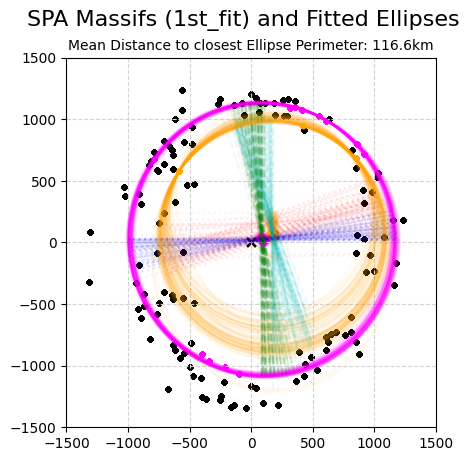

azimuth deviation: 2.44e+00
azimuth deviation: 1.80e+00
azimuth deviation: 1.02e+01
azimuth deviation: 9.34e-01
azimuth deviation: 7.74e+00
azimuth deviation: 1.70e+01
azimuth deviation: 1.36e+01
azimuth deviation: 3.73e+00
azimuth deviation: 8.13e+00
azimuth deviation: 1.87e+01
azimuth deviation: 3.83e+00
azimuth deviation: 6.50e+00
azimuth deviation: 9.18e-01
azimuth deviation: 1.05e+01
azimuth deviation: 2.10e+00
azimuth deviation: 1.57e+00
azimuth deviation: 1.84e+00
azimuth deviation: 6.03e+00
azimuth deviation: 1.23e+01
azimuth deviation: 9.47e+00
azimuth deviation: 6.45e+00
azimuth deviation: 4.43e+00
azimuth deviation: 7.58e+00
azimuth deviation: 2.30e+00
azimuth deviation: 5.91e+00
azimuth deviation: 3.15e+00
azimuth deviation: 1.52e+00
azimuth deviation: 2.25e+00
azimuth deviation: 1.96e-02
azimuth deviation: 7.20e-01
azimuth deviation: 2.76e-01
azimuth deviation: 7.79e+00
azimuth deviation: 1.38e+01
azimuth deviation: 4.50e+00
azimuth deviation: 1.30e+01
azimuth deviation: 3

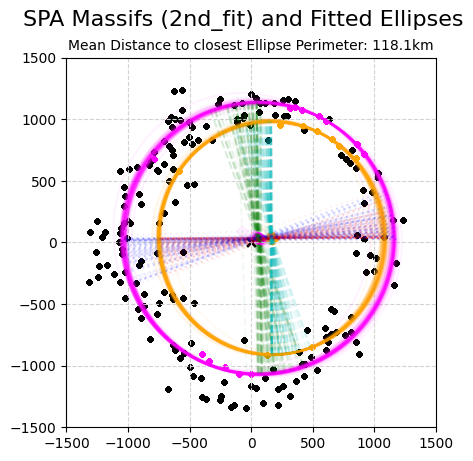

azimuth deviation: 9.30e+00
azimuth deviation: 4.39e+00
azimuth deviation: 1.56e+01
azimuth deviation: 8.40e+00
azimuth deviation: 5.79e+00
azimuth deviation: 6.56e+00
azimuth deviation: 1.15e+01
azimuth deviation: 9.95e+00
azimuth deviation: 9.53e+00
azimuth deviation: 6.42e+00
azimuth deviation: 8.01e+00
azimuth deviation: 1.02e+01
azimuth deviation: 5.70e+00
azimuth deviation: 1.94e+01
azimuth deviation: 1.41e+01
azimuth deviation: 2.56e+00
azimuth deviation: 3.28e+00
azimuth deviation: 8.68e+00
azimuth deviation: 7.74e+00
azimuth deviation: 2.13e+00
azimuth deviation: 1.49e+01
azimuth deviation: 1.88e+00
azimuth deviation: 1.76e+01
azimuth deviation: 8.12e+00
azimuth deviation: 1.88e+00
azimuth deviation: 1.29e-01
azimuth deviation: 1.70e+01
azimuth deviation: 2.77e+00
azimuth deviation: 1.50e+00
azimuth deviation: 2.16e-02
azimuth deviation: 5.74e+00
azimuth deviation: 4.15e+00
azimuth deviation: 3.30e-01
azimuth deviation: 1.40e+01
azimuth deviation: 9.84e+00
azimuth deviation: 7

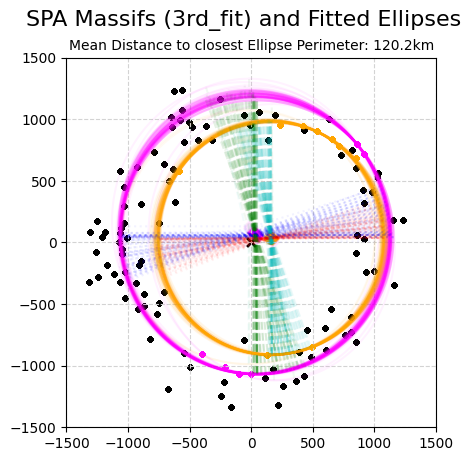

updating: images/ (stored 0%)
updating: images/2nd_fit_bestloss.png (deflated 6%)
updating: images/1st_fit_bestloss.png (deflated 6%)
updating: images/3rd_fit_bestloss.png (deflated 6%)
updating: images/3rd_fit.png (deflated 2%)
updating: images/2nd_fit.png (deflated 2%)
updating: images/1st_fit.png (deflated 2%)
updating: images/2nd_fit_medianvalues.png (deflated 6%)
updating: images/1st_fit_medianvalues.png (deflated 6%)
updating: images/3rd_fit_medianvalues.png (deflated 6%)


In [ ]:
ALPHA = 0.05

for fit in ["1st_fit", "2nd_fit", "3rd_fit"]:
  sum_loss = 0.0
  n = 0
  for result in results[fit]:
    params_outer = result['params_outer']
    params_inner = result['params_inner']

    loss = result['loss']
    sum_loss += loss
    n += 1
    # TODO: sets
    sets = fit_to_coord[fit]
    for set_name, color in [('dynamic', 'black'), ('outer', 'magenta'), ('inner', 'orange')]:
      lats, lons = sets[set_name][:, 0], sets[set_name][:, 1]
      latitudes = torch.tensor(lats, dtype=torch.float64)
      longitudes = torch.tensor(lons, dtype=torch.float64)
      x, y = orthographic_projection_torch(latitudes, longitudes, central_lat, central_lon, R_MOON)

      fig = plt.Figure((10, 10))
      plt.scatter(x, y, s=10, label=f'Massif Locations ({set_name})', color=color, marker="o")

    plt.scatter((0,), (0,), marker="x", label="Projection Center (56°S, 180°E)", color="black", alpha=ALPHA)

    # Ellipse 1
    centerx, centery, semimajor, semiminor_factor, rotation_rad = [x.detach().cpu().numpy() for x in express_parameters(params_outer)]
    semiminor = semimajor * semiminor_factor

    rotation_deg = rotation_rad * 180 / np.pi
    rotation_deg = rotation_deg % 360
    r1 = rotation_deg

    points = generate_ellipse_points(params_outer, 1.0, num_points=1000)
    points = points.detach().cpu().numpy()

    plt.plot(points[:, 0], points[:, 1], color="magenta", label="Outer Ellipse", alpha=ALPHA)

    plt.scatter((centerx,), (centery,), marker="D", label="Ellipse 1 Center (%.1fkm, %.1fkm)" % (centerx, centery), color="magenta", alpha=ALPHA)

    # Calculate and plot the semi-major and semi-minor axes
    semi_major_endpoints = np.array([
        [centerx - semimajor * np.cos(rotation_rad), centery - semimajor * np.sin(rotation_rad)],
        [centerx + semimajor * np.cos(rotation_rad), centery + semimajor * np.sin(rotation_rad)]
    ])
    plt.plot(semi_major_endpoints[:, 0], semi_major_endpoints[:, 1], 'g--', label="E1 Outer Semi-major Axis (%.1fkm)" % semimajor, alpha=ALPHA)

    semi_minor_endpoints = np.array([
        [centerx + semiminor * np.sin(rotation_rad), centery - semiminor * np.cos(rotation_rad)],
        [centerx - semiminor * np.sin(rotation_rad), centery + semiminor * np.cos(rotation_rad)]
    ])
    plt.plot(semi_minor_endpoints[:, 0], semi_minor_endpoints[:, 1], 'b--', label="E1 Outer Semi-minor Axis (%.1fkm)" % semiminor, linestyle="dotted", alpha=ALPHA)

    # dummy plot for extra label
    plt.plot([], [], ' ', label="E1 Orientation %.2f° (North=90°, East=0°, ccw)" % rotation_deg, alpha=ALPHA)
    ellipticity = semimajor / semiminor
    plt.plot([], [], ' ', label="E1 Ellipticity %.2f" % ellipticity, alpha=ALPHA)

    #print("----------------------")

    # Ellipse 2
    centerx, centery, semimajor, semiminor_factor, rotation_rad = [x.detach().cpu().numpy() for x in express_parameters(params_inner)]
    semiminor = semimajor * semiminor_factor

    rotation_deg = rotation_rad * 180 / np.pi
    rotation_deg = rotation_deg % 360
    r2 = rotation_deg

    if np.abs(r1-r2) > 0.001:
      print("azimuth deviation: %.2e" % np.abs(r1-r2))

    points = generate_ellipse_points(params_inner, 1.0, num_points=1000)
    points = points.detach().cpu().numpy()

    plt.plot(points[:, 0], points[:, 1], color="orange", label="Inner Ellipse", alpha=ALPHA)

    plt.scatter((centerx,), (centery,), marker="D", label="Ellipse 2 Center (%.1fkm, %.1fkm)" % (centerx, centery), color="orange", alpha=ALPHA)

    # Calculate and plot the semi-major and semi-minor axes
    semi_major_endpoints = np.array([
        [centerx - semimajor * np.cos(rotation_rad), centery - semimajor * np.sin(rotation_rad)],
        [centerx + semimajor * np.cos(rotation_rad), centery + semimajor * np.sin(rotation_rad)]
    ])
    plt.plot(semi_major_endpoints[:, 0], semi_major_endpoints[:, 1], 'c--', label="E2 Inner Semi-major Axis (%.1fkm)" % semimajor, alpha=ALPHA)

    semi_minor_endpoints = np.array([
        [centerx + semiminor * np.sin(rotation_rad), centery - semiminor * np.cos(rotation_rad)],
        [centerx - semiminor * np.sin(rotation_rad), centery + semiminor * np.cos(rotation_rad)]
    ])
    plt.plot(semi_minor_endpoints[:, 0], semi_minor_endpoints[:, 1], 'r--', label="E2 Inner Semi-minor Axis (%.1fkm)" % semiminor, linestyle="dotted", alpha=ALPHA)

    # dummy plot for extra label
    plt.plot([], [], ' ', label="E2 Orientation %.2f° (North=90°, East=0°, ccw)" % rotation_deg)
    ellipticity = semimajor / semiminor
    plt.plot([], [], ' ', label="E2 Ellipticity %.2f" % ellipticity)

    # -------------- #
    plt.plot([], [], ' ', label="Loss %.2f" % loss)

  plt.ylim((-1500, 1500))
  plt.xlim((-1500, 1500))

  ax = plt.gca()
  ax.set_aspect('equal', 'box')

  fig.tight_layout()

  plt.grid(color='lightgray',linestyle='--')
  plt.suptitle(f"SPA Massifs ({fit}) and Fitted Ellipses", fontsize=16)
  plt.title("Mean Distance to closest Ellipse Perimeter: %.1fkm" % (sum_loss / n), fontsize=10)
  plt.savefig(f"images/{fit}.png", dpi=fig.dpi)
  plt.show()

!zip -r images.zip images/

 Ellipse 1:
center x [km]: 70.33318671650873
center y [km]: 50.83450366082065
semi-major [km]: 1100.4447879795841
semi-minor [km]: 1047.4602096958238
orientation [radians]: 1.5909088589511793
orientation [deg]: 91.15236320787615
----------------------
Ellipse 2:
azimuth deviation: 8.81e-01
center x [km]: 180.36761424489288
center y [km]: -115.85058121617503
semi-major [km]: 1100.4447879795841
semi-minor [km]: 981.3570062305305
orientation [radians]: 1.6062892880003343
orientation [deg]: 92.03359687949315


<ipython-input-40-5fabdabdd5cc>:72: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(semi_minor_endpoints[:, 0], semi_minor_endpoints[:, 1], 'b--', label="E1 Outer Semi-minor Axis (%.1fkm)" % semiminor, linestyle="dotted", alpha=ALPHA)
<ipython-input-40-5fabdabdd5cc>:114: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(semi_minor_endpoints[:, 0], semi_minor_endpoints[:, 1], 'r--', label="E2 Inner Semi-minor Axis (%.1fkm)" % semiminor, linestyle="dotted", alpha=ALPHA)


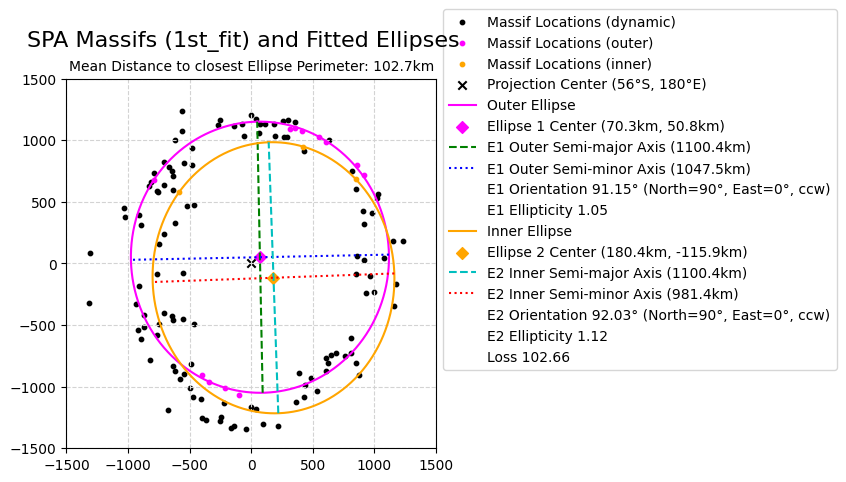

 Ellipse 1:
center x [km]: 62.182847985729374
center y [km]: 33.01698835373384
semi-major [km]: 1105.3725609340106
semi-minor [km]: 1098.8642788590812
orientation [radians]: 1.9016099606642314
orientation [deg]: 108.95422502609895
----------------------
Ellipse 2:
azimuth deviation: 1.87e+01
center x [km]: 163.5984764358922
center y [km]: 34.24220105687211
semi-major [km]: 945.9545474574725
semi-minor [km]: 917.3327815024193
orientation [radians]: 1.574811479785148
orientation [deg]: 90.23005132044074


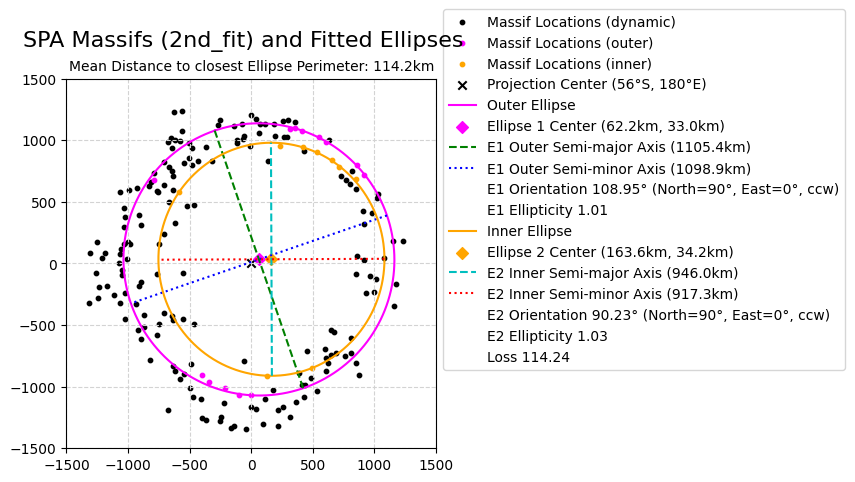

 Ellipse 1:
center x [km]: 38.99512220460047
center y [km]: 69.9092172307668
semi-major [km]: 1146.8784318636042
semi-minor [km]: 1087.5152142869501
orientation [radians]: 1.8770783762214591
orientation [deg]: 107.54866877275931
----------------------
Ellipse 2:
azimuth deviation: 1.69e+01
center x [km]: 156.2643293933885
center y [km]: 37.46352779762937
semi-major [km]: 950.1318929317534
semi-minor [km]: 906.004389694377
orientation [radians]: 1.5824922488346882
orientation [deg]: 90.67012697039411


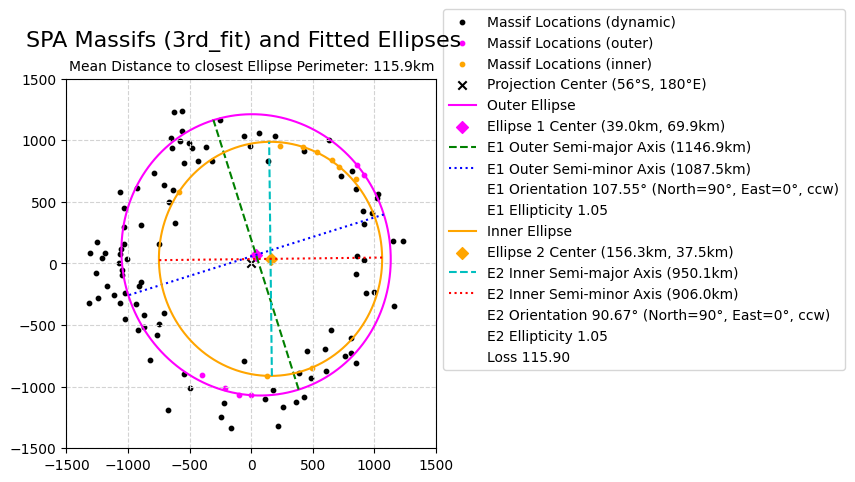

  adding: images/ (stored 0%)
  adding: images/2nd_fit_medianvalues.png (deflated 5%)
  adding: images/2nd_fit_bestloss.png (deflated 5%)
  adding: images/1st_fit_bestloss.png (deflated 6%)
  adding: images/3rd_fit_bestloss.png (deflated 6%)
  adding: images/3rd_fit.png (deflated 2%)
  adding: images/1st_fit_medianvalues.png (deflated 6%)
  adding: images/3rd_fit_medianvalues.png (deflated 6%)
  adding: images/2nd_fit.png (deflated 2%)
  adding: images/1st_fit.png (deflated 2%)


In [ ]:
# best loss
ALPHA = 1.0

for fit in ["1st_fit", "2nd_fit", "3rd_fit"]:
  best_loss = np.inf
  best_result = None

  # search best ellipse
  for result in results[fit]:
    params_outer = result['params_outer']
    params_inner = result['params_inner']

    loss = result['loss']
    if loss < best_loss:
      best_loss = loss
      best_result = result

  # reload best result
  result = best_result
  loss = result['loss']
  params_outer = result['params_outer']
  params_inner = result['params_inner']

  sets = fit_to_coord[fit]
  for set_name, color in [('dynamic', 'black'), ('outer', 'magenta'), ('inner', 'orange')]:
    lats, lons = sets[set_name][:, 0], sets[set_name][:, 1]
    latitudes = torch.tensor(lats, dtype=torch.float64)
    longitudes = torch.tensor(lons, dtype=torch.float64)
    x, y = orthographic_projection_torch(latitudes, longitudes, central_lat, central_lon, R_MOON)

    fig = plt.Figure((10, 10))
    plt.scatter(x, y, s=10, label=f'Massif Locations ({set_name})', color=color, marker="o")

  plt.scatter((0,), (0,), marker="x", label="Projection Center (56°S, 180°E)", color="black", alpha=ALPHA)

  # Ellipse 1
  print(" Ellipse 1:")

  centerx, centery, semimajor, semiminor_factor, rotation_rad = [x.detach().cpu().numpy() for x in express_parameters(params_outer)]
  semiminor = semimajor * semiminor_factor

  rotation_deg = rotation_rad * 180 / np.pi
  rotation_deg = rotation_deg % 360
  r1 = rotation_deg

  for name, p in zip(["center x [km]", "center y [km]", "semi-major [km]", "semi-minor [km]", "orientation [radians]", "orientation [deg]"], [centerx, centery, semimajor, semiminor, rotation_rad, rotation_deg]):
   print(f"{name}: {p}")

  points = generate_ellipse_points(params_outer, 1.0, num_points=1000)
  points = points.detach().cpu().numpy()

  plt.plot(points[:, 0], points[:, 1], color="magenta", label="Outer Ellipse", alpha=ALPHA)

  plt.scatter((centerx,), (centery,), marker="D", label="Ellipse 1 Center (%.1fkm, %.1fkm)" % (centerx, centery), color="magenta", alpha=ALPHA)

  # Calculate and plot the semi-major and semi-minor axes
  semi_major_endpoints = np.array([
      [centerx - semimajor * np.cos(rotation_rad), centery - semimajor * np.sin(rotation_rad)],
      [centerx + semimajor * np.cos(rotation_rad), centery + semimajor * np.sin(rotation_rad)]
  ])
  plt.plot(semi_major_endpoints[:, 0], semi_major_endpoints[:, 1], 'g--', label="E1 Outer Semi-major Axis (%.1fkm)" % semimajor, alpha=ALPHA)

  semi_minor_endpoints = np.array([
      [centerx + semiminor * np.sin(rotation_rad), centery - semiminor * np.cos(rotation_rad)],
      [centerx - semiminor * np.sin(rotation_rad), centery + semiminor * np.cos(rotation_rad)]
  ])
  plt.plot(semi_minor_endpoints[:, 0], semi_minor_endpoints[:, 1], 'b--', label="E1 Outer Semi-minor Axis (%.1fkm)" % semiminor, linestyle="dotted", alpha=ALPHA)

  # dummy plot for extra label
  plt.plot([], [], ' ', label="E1 Orientation %.2f° (North=90°, East=0°, ccw)" % rotation_deg, alpha=ALPHA)
  ellipticity = semimajor / semiminor
  plt.plot([], [], ' ', label="E1 Ellipticity %.2f" % ellipticity, alpha=ALPHA)

  print("----------------------")

  # Ellipse 2
  print("Ellipse 2:")
  centerx, centery, semimajor, semiminor_factor, rotation_rad = [x.detach().cpu().numpy() for x in express_parameters(params_inner)]
  semiminor = semimajor * semiminor_factor

  rotation_deg = rotation_rad * 180 / np.pi
  rotation_deg = rotation_deg % 360
  r2 = rotation_deg

  if np.abs(r1-r2) > 0.001:
    print("azimuth deviation: %.2e" % np.abs(r1-r2))
  for name, p in zip(["center x [km]", "center y [km]", "semi-major [km]", "semi-minor [km]", "orientation [radians]", "orientation [deg]"], [centerx, centery, semimajor, semiminor, rotation_rad, rotation_deg]):
   print(f"{name}: {p}")

  points = generate_ellipse_points(params_inner, 1.0, num_points=1000)
  points = points.detach().cpu().numpy()

  plt.plot(points[:, 0], points[:, 1], color="orange", label="Inner Ellipse", alpha=ALPHA)

  plt.scatter((centerx,), (centery,), marker="D", label="Ellipse 2 Center (%.1fkm, %.1fkm)" % (centerx, centery), color="orange", alpha=ALPHA)

  # Calculate and plot the semi-major and semi-minor axes
  semi_major_endpoints = np.array([
      [centerx - semimajor * np.cos(rotation_rad), centery - semimajor * np.sin(rotation_rad)],
      [centerx + semimajor * np.cos(rotation_rad), centery + semimajor * np.sin(rotation_rad)]
  ])
  plt.plot(semi_major_endpoints[:, 0], semi_major_endpoints[:, 1], 'c--', label="E2 Inner Semi-major Axis (%.1fkm)" % semimajor, alpha=ALPHA)

  semi_minor_endpoints = np.array([
      [centerx + semiminor * np.sin(rotation_rad), centery - semiminor * np.cos(rotation_rad)],
      [centerx - semiminor * np.sin(rotation_rad), centery + semiminor * np.cos(rotation_rad)]
  ])
  plt.plot(semi_minor_endpoints[:, 0], semi_minor_endpoints[:, 1], 'r--', label="E2 Inner Semi-minor Axis (%.1fkm)" % semiminor, linestyle="dotted", alpha=ALPHA)

  # dummy plot for extra label
  plt.plot([], [], ' ', label="E2 Orientation %.2f° (North=90°, East=0°, ccw)" % rotation_deg)
  ellipticity = semimajor / semiminor
  plt.plot([], [], ' ', label="E2 Ellipticity %.2f" % ellipticity)

  # -------------- #
  plt.plot([], [], ' ', label="Loss %.2f" % loss)

  plt.ylim((-1500, 1500))
  plt.xlim((-1500, 1500))

  ax = plt.gca()
  ax.set_aspect('equal', 'box')

  ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.70))

  plt.grid(color='lightgray',linestyle='--')
  plt.suptitle(f"SPA Massifs ({fit}) and Fitted Ellipses", fontsize=16)
  plt.title("Mean Distance to closest Ellipse Perimeter: %.1fkm" % loss, fontsize=10)
  plt.savefig(f"images/{fit}_bestloss.png", dpi=fig.dpi)
  plt.show()

!zip -r images.zip images/

In [ ]:
# best loss
def inverse_orthographic_projection_numpy(x, y, central_lat, central_lon, radius):
    """
    Transform scalar x, y coordinates back to latitude and longitude on a spherical body using NumPy.

    :param x: X coordinate in km, offset from the orthographic center.
    :param y: Y coordinate in km, offset from the orthographic center.
    :param central_lat: Latitude of the orthographic projection center in degrees.
    :param central_lon: Longitude of the orthographic projection center in degrees.
    :param radius: Radius of the spherical body in km.
    :return: lat, lon - Transformed latitude and longitude coordinates.
    """
    # Convert degrees to radians
    central_lat_rad = np.radians(central_lat)
    central_lon_rad = np.radians(central_lon)

    # Calculate rho and c
    rho = np.sqrt(x**2 + y**2)
    c = np.arcsin(rho / radius)

    # Compute latitude and longitude
    if rho != 0:
        lat_rad = np.arcsin(np.cos(c) * np.sin(central_lat_rad) + (y * np.sin(c) * np.cos(central_lat_rad) / rho))
        lon_rad = central_lon_rad + np.arctan2(x * np.sin(c), (rho * np.cos(central_lat_rad) * np.cos(c) - y * np.sin(central_lat_rad) * np.sin(c)))
    else:
        lat_rad = central_lat_rad
        lon_rad = central_lon_rad

    # Convert radians back to degrees
    lat = np.degrees(lat_rad)
    lon = np.degrees(lon_rad)

    return lat, lon

header = ['x-coordinate field of ellipse center point (lon)', 'y-coordinate field of ellipse center point (lat)', 'major-axis length (km)', 'minor-axis length (km)', 'azimuth of semimajor axis (degrees)', 'loss']
for fit in ["1st_fit", "2nd_fit", "3rd_fit"]:

  # search best ellipse
  for result in results[fit]:
    params_outer = result['params_outer']
    params_inner = result['params_inner']

    loss = result['loss']
    if loss < best_loss:
      best_loss = loss
      best_result = result

  # reload best result
  res = best_result

  with open(f'results/{fit}_bestloss_outer.csv', 'w') as outer_file:
    with open(f'results/{fit}_bestloss_inner.csv', 'w') as inner_file:
      outer_writer = csv.writer(outer_file, delimiter=';')
      inner_writer = csv.writer(inner_file, delimiter=';')
      outer_writer.writerow(header)
      inner_writer.writerow(header)

      params_outer = res["params_outer"]
      params_inner = res["params_inner"]
      loss = res["loss"]
      ellipse_center_x, ellipse_center_y, semimajor, semiminor_factor, azimuth_rad = [x.detach().cpu().numpy() for x in express_parameters(params_outer)]
      semiminor = semimajor * semiminor_factor

      major = 2 * semimajor
      minor = 2 * semiminor

      center_lat, center_lon = inverse_orthographic_projection_numpy(ellipse_center_x, ellipse_center_y, -56, -180, R_MOON)

      azimuth_deg = azimuth_rad * 180 / np.pi
      # normalize angle, so 0° is north (clockwise)
      azimuth_deg = (90 - azimuth_deg) % 360

      outer_writer.writerow([center_lon, center_lat, major, minor, azimuth_deg, loss])

      ellipse_center_x, ellipse_center_y, semimajor, semiminor_factor, azimuth_rad = [x.detach().cpu().numpy() for x in express_parameters(params_inner)]
      semiminor = semimajor * semiminor_factor

      major = 2 * semimajor
      minor = 2 * semiminor

      center_lat, center_lon = inverse_orthographic_projection_numpy(ellipse_center_x, ellipse_center_y, -56, -180, R_MOON)

      azimuth_deg = azimuth_rad * 180 / np.pi
      # normalize angle, so 0° is north (clockwise)
      azimuth_deg = (90 - azimuth_deg) % 360

      inner_writer.writerow([center_lon, center_lat, major, minor, azimuth_deg, loss])


 Ellipse 1:
center x [km]: 88.53569055524929
center y [km]: 25.393590202516396
semi-major [km]: 1106.1882593738753
semi-minor [km]: 1074.1275179971608
orientation [radians]: 1.6450842476278704
orientation [deg]: 94.25638433253138
----------------------
Ellipse 2:
azimuth deviation: 8.18e+00
center x [km]: 171.39478804246207
center y [km]: 82.28006977995622
semi-major [km]: 916.777182105969
semi-minor [km]: 908.1222714068016
orientation [radians]: 1.787856023519758
orientation [deg]: 102.43660452472419


<ipython-input-37-c0ee2b718dbd>:76: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(semi_minor_endpoints[:, 0], semi_minor_endpoints[:, 1], 'b--', label="E1 Outer Semi-minor Axis (%.1fkm)" % semiminor, linestyle="dotted", alpha=ALPHA)
<ipython-input-37-c0ee2b718dbd>:118: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(semi_minor_endpoints[:, 0], semi_minor_endpoints[:, 1], 'r--', label="E2 Inner Semi-minor Axis (%.1fkm)" % semiminor, linestyle="dotted", alpha=ALPHA)


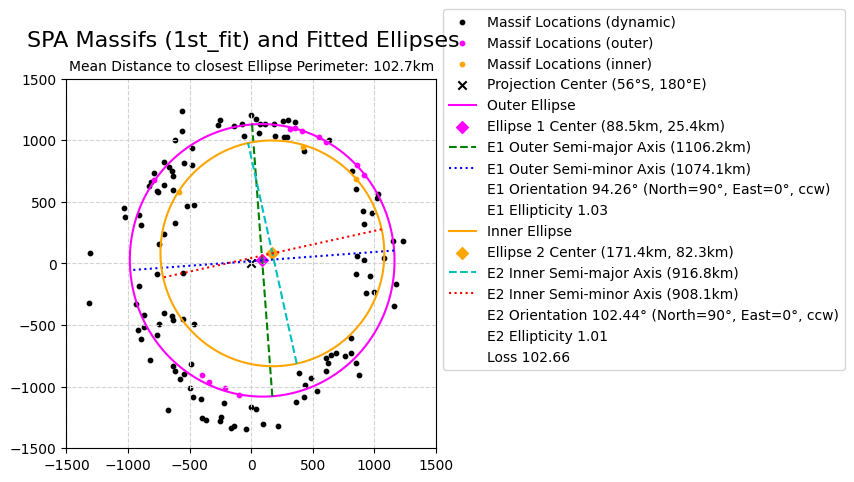

 Ellipse 1:
center x [km]: 60.96807872413123
center y [km]: 33.96385110375926
semi-major [km]: 1104.0029354734631
semi-minor [km]: 1097.935667357435
orientation [radians]: 1.6529120212719124
orientation [deg]: 94.70488272531873
----------------------
Ellipse 2:
azimuth deviation: 1.69e+00
center x [km]: 163.77767470858757
center y [km]: 35.96091327801917
semi-major [km]: 946.8283487958109
semi-minor [km]: 916.7897076035832
orientation [radians]: 1.6234041616090655
orientation [deg]: 93.01420690417329


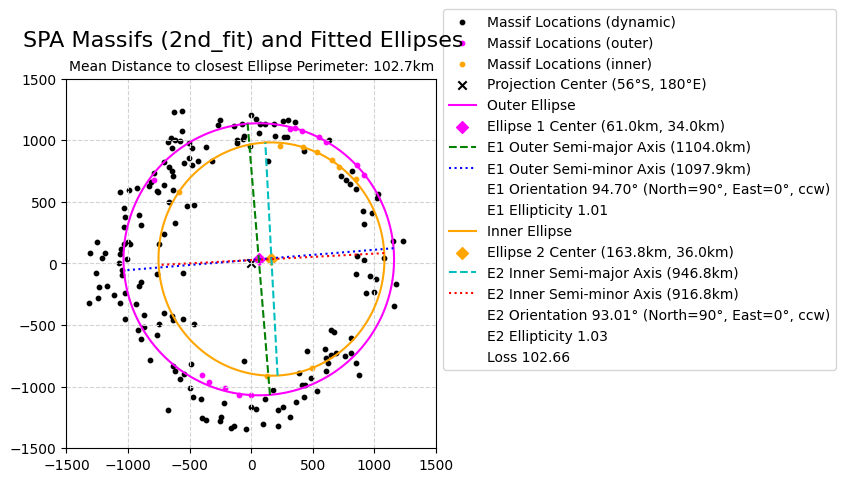

 Ellipse 1:
center x [km]: 30.914124743573332
center y [km]: 63.869762807944056
semi-major [km]: 1135.4948472179979
semi-minor [km]: 1087.5593588473512
orientation [radians]: 1.6615442124283426
orientation [deg]: 95.19947084653234
----------------------
Ellipse 2:
azimuth deviation: 7.42e-01
center x [km]: 159.48424258678432
center y [km]: 36.24660259909767
semi-major [km]: 948.2398038324287
semi-minor [km]: 919.1083655275231
orientation [radians]: 1.674494433091901
orientation [deg]: 95.94146383431735


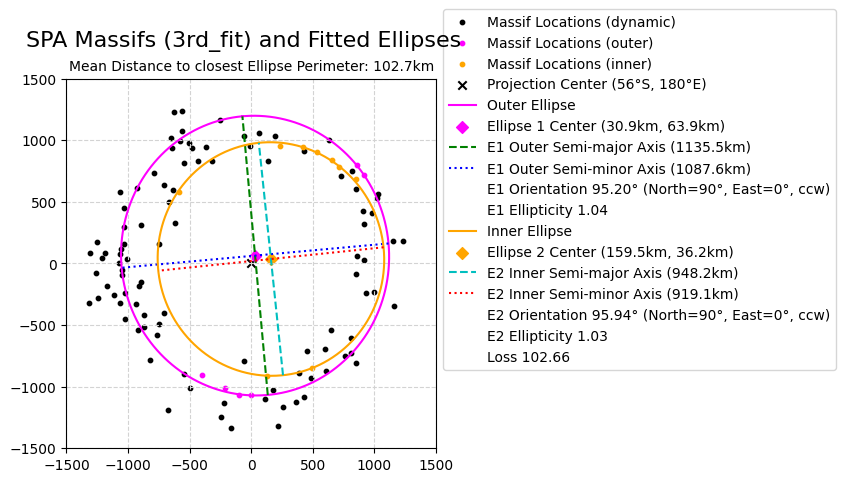

updating: images/ (stored 0%)
updating: images/2nd_fit_bestloss.png (deflated 5%)
updating: images/1st_fit_bestloss.png (deflated 6%)
updating: images/3rd_fit_bestloss.png (deflated 6%)
updating: images/3rd_fit.png (deflated 2%)
updating: images/2nd_fit.png (deflated 2%)
updating: images/1st_fit.png (deflated 2%)
updating: images/2nd_fit_medianvalues.png (deflated 5%)
updating: images/1st_fit_medianvalues.png (deflated 6%)
updating: images/3rd_fit_medianvalues.png (deflated 6%)


In [ ]:
# median values

ALPHA = 1.0

for fit in ["1st_fit", "2nd_fit", "3rd_fit"]:

  reslist_outer = []
  reslist_inner = []
  losses = []

  for result in results[fit]:
    params_outer = result['params_outer']
    params_inner = result['params_inner']
    if len(reslist_outer) == 0:
      for p in params_outer:
        reslist_outer.append([p])
      for p in params_outer:
        reslist_inner.append([p])
    else:
      for p, l in zip(params_outer, reslist_outer):
        l.append(p)
      for p, l in zip(params_inner, reslist_inner):
        l.append(p)
    losses.append(loss)

  params_outer = [torch.median(torch.tensor(l)) for l in reslist_outer]
  params_inner = [torch.median(torch.tensor(l)) for l in reslist_inner]

  sets = fit_to_coord[fit]
  for set_name, color in [('dynamic', 'black'), ('outer', 'magenta'), ('inner', 'orange')]:
    lats, lons = sets[set_name][:, 0], sets[set_name][:, 1]
    latitudes = torch.tensor(lats, dtype=torch.float64)
    longitudes = torch.tensor(lons, dtype=torch.float64)
    x, y = orthographic_projection_torch(latitudes, longitudes, central_lat, central_lon, R_MOON)

    fig = plt.Figure((10, 10))
    plt.scatter(x, y, s=10, label=f'Massif Locations ({set_name})', color=color, marker="o")

  plt.scatter((0,), (0,), marker="x", label="Projection Center (56°S, 180°E)", color="black", alpha=ALPHA)

  # Ellipse 1
  print(" Ellipse 1:")

  centerx, centery, semimajor, semiminor_factor, rotation_rad = [x.detach().cpu().numpy() for x in express_parameters(params_outer)]
  semiminor = semimajor * semiminor_factor

  rotation_deg = rotation_rad * 180 / np.pi
  rotation_deg = rotation_deg % 360
  r1 = rotation_deg

  for name, p in zip(["center x [km]", "center y [km]", "semi-major [km]", "semi-minor [km]", "orientation [radians]", "orientation [deg]"], [centerx, centery, semimajor, semiminor, rotation_rad, rotation_deg]):
   print(f"{name}: {p}")

  points = generate_ellipse_points(params_outer, 1.0, num_points=1000)
  points = points.detach().cpu().numpy()

  plt.plot(points[:, 0], points[:, 1], color="magenta", label="Outer Ellipse", alpha=ALPHA)

  plt.scatter((centerx,), (centery,), marker="D", label="Ellipse 1 Center (%.1fkm, %.1fkm)" % (centerx, centery), color="magenta", alpha=ALPHA)

  # Calculate and plot the semi-major and semi-minor axes
  semi_major_endpoints = np.array([
      [centerx - semimajor * np.cos(rotation_rad), centery - semimajor * np.sin(rotation_rad)],
      [centerx + semimajor * np.cos(rotation_rad), centery + semimajor * np.sin(rotation_rad)]
  ])
  plt.plot(semi_major_endpoints[:, 0], semi_major_endpoints[:, 1], 'g--', label="E1 Outer Semi-major Axis (%.1fkm)" % semimajor, alpha=ALPHA)

  semi_minor_endpoints = np.array([
      [centerx + semiminor * np.sin(rotation_rad), centery - semiminor * np.cos(rotation_rad)],
      [centerx - semiminor * np.sin(rotation_rad), centery + semiminor * np.cos(rotation_rad)]
  ])
  plt.plot(semi_minor_endpoints[:, 0], semi_minor_endpoints[:, 1], 'b--', label="E1 Outer Semi-minor Axis (%.1fkm)" % semiminor, linestyle="dotted", alpha=ALPHA)

  plt.plot([], [], ' ', label="E1 Orientation %.2f° (North=90°, East=0°, ccw)" % rotation_deg, alpha=ALPHA)
  ellipticity = semimajor / semiminor
  plt.plot([], [], ' ', label="E1 Ellipticity %.2f" % ellipticity, alpha=ALPHA)

  print("----------------------")

  # Ellipse 2
  print("Ellipse 2:")
  centerx, centery, semimajor, semiminor_factor, rotation_rad = [x.detach().cpu().numpy() for x in express_parameters(params_inner)]
  semiminor = semimajor * semiminor_factor

  rotation_deg = rotation_rad * 180 / np.pi
  rotation_deg = rotation_deg % 360
  r2 = rotation_deg

  if np.abs(r1-r2) > 0.001:
    print("azimuth deviation: %.2e" % np.abs(r1-r2))
  for name, p in zip(["center x [km]", "center y [km]", "semi-major [km]", "semi-minor [km]", "orientation [radians]", "orientation [deg]"], [centerx, centery, semimajor, semiminor, rotation_rad, rotation_deg]):
   print(f"{name}: {p}")

  points = generate_ellipse_points(params_inner, 1.0, num_points=1000)
  points = points.detach().cpu().numpy()

  plt.plot(points[:, 0], points[:, 1], color="orange", label="Inner Ellipse", alpha=ALPHA)

  plt.scatter((centerx,), (centery,), marker="D", label="Ellipse 2 Center (%.1fkm, %.1fkm)" % (centerx, centery), color="orange", alpha=ALPHA)

  # Calculate and plot the semi-major and semi-minor axes
  semi_major_endpoints = np.array([
      [centerx - semimajor * np.cos(rotation_rad), centery - semimajor * np.sin(rotation_rad)],
      [centerx + semimajor * np.cos(rotation_rad), centery + semimajor * np.sin(rotation_rad)]
  ])
  plt.plot(semi_major_endpoints[:, 0], semi_major_endpoints[:, 1], 'c--', label="E2 Inner Semi-major Axis (%.1fkm)" % semimajor, alpha=ALPHA)

  semi_minor_endpoints = np.array([
      [centerx + semiminor * np.sin(rotation_rad), centery - semiminor * np.cos(rotation_rad)],
      [centerx - semiminor * np.sin(rotation_rad), centery + semiminor * np.cos(rotation_rad)]
  ])
  plt.plot(semi_minor_endpoints[:, 0], semi_minor_endpoints[:, 1], 'r--', label="E2 Inner Semi-minor Axis (%.1fkm)" % semiminor, linestyle="dotted", alpha=ALPHA)

  # dummy plot for extra label
  plt.plot([], [], ' ', label="E2 Orientation %.2f° (North=90°, East=0°, ccw)" % rotation_deg)
  ellipticity = semimajor / semiminor
  plt.plot([], [], ' ', label="E2 Ellipticity %.2f" % ellipticity)

  # -------------- #
  plt.plot([], [], ' ', label="Loss %.2f" % loss)

  plt.ylim((-1500, 1500))
  plt.xlim((-1500, 1500))

  ax = plt.gca()
  ax.set_aspect('equal', 'box')

  ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.70))

  fig.tight_layout()

  plt.grid(color='lightgray',linestyle='--')
  plt.suptitle(f"SPA Massifs ({fit}) and Fitted Ellipses", fontsize=16)
  plt.title("Mean Distance to closest Ellipse Perimeter: %.1fkm" % loss, fontsize=10)
  plt.savefig(f"images/{fit}_medianvalues.png", dpi=fig.dpi)
  plt.show()

!zip -r images.zip images/

In [ ]:
# median values
def inverse_orthographic_projection_numpy(x, y, central_lat, central_lon, radius):
    """
    Transform scalar x, y coordinates back to latitude and longitude on a spherical body using NumPy.

    :param x: X coordinate in km, offset from the orthographic center.
    :param y: Y coordinate in km, offset from the orthographic center.
    :param central_lat: Latitude of the orthographic projection center in degrees.
    :param central_lon: Longitude of the orthographic projection center in degrees.
    :param radius: Radius of the spherical body in km.
    :return: lat, lon - Transformed latitude and longitude coordinates.
    """
    # Convert degrees to radians
    central_lat_rad = np.radians(central_lat)
    central_lon_rad = np.radians(central_lon)

    # Calculate rho and c
    rho = np.sqrt(x**2 + y**2)
    c = np.arcsin(rho / radius)

    # Compute latitude and longitude
    if rho != 0:
        lat_rad = np.arcsin(np.cos(c) * np.sin(central_lat_rad) + (y * np.sin(c) * np.cos(central_lat_rad) / rho))
        lon_rad = central_lon_rad + np.arctan2(x * np.sin(c), (rho * np.cos(central_lat_rad) * np.cos(c) - y * np.sin(central_lat_rad) * np.sin(c)))
    else:
        lat_rad = central_lat_rad
        lon_rad = central_lon_rad

    # Convert radians back to degrees
    lat = np.degrees(lat_rad)
    lon = np.degrees(lon_rad)

    return lat, lon


header = ['x-coordinate field of ellipse center point (lon)', 'y-coordinate field of ellipse center point (lat)', 'major-axis length (km)', 'minor-axis length (km)', 'azimuth of semimajor axis (degrees)', 'loss']
for fit in ["1st_fit", "2nd_fit", "3rd_fit"]:


  reslist_outer = []
  reslist_inner = []

  for result in results[fit]:
    params_outer = result['params_outer']
    params_inner = result['params_inner']
    if len(reslist_outer) == 0:
      for p in params_outer:
        reslist_outer.append([p])
      for p in params_outer:
        reslist_inner.append([p])
    else:
      for p, l in zip(params_outer, reslist_outer):
        l.append(p)
      for p, l in zip(params_inner, reslist_inner):
        l.append(p)

  params_outer = [torch.median(torch.tensor(l)) for l in reslist_outer]
  params_inner = [torch.median(torch.tensor(l)) for l in reslist_inner]

  with open(f'results/{fit}_medianvalues_outer.csv', 'w') as outer_file:
    with open(f'results/{fit}_medianvalues_inner.csv', 'w') as inner_file:
      outer_writer = csv.writer(outer_file, delimiter=';')
      inner_writer = csv.writer(inner_file, delimiter=';')
      outer_writer.writerow(header)
      inner_writer.writerow(header)

      ellipse_center_x, ellipse_center_y, semimajor, semiminor_factor, azimuth_rad = [x.detach().cpu().numpy() for x in express_parameters(params_outer)]
      semiminor = semimajor * semiminor_factor

      major = 2 * semimajor
      minor = 2 * semiminor

      center_lat, center_lon = inverse_orthographic_projection_numpy(ellipse_center_x, ellipse_center_y, -56, -180, R_MOON)

      azimuth_deg = azimuth_rad * 180 / np.pi
      # normalize angle, so 0° is north and its clockwise
      azimuth_deg = (90 - azimuth_deg) % 360

      outer_writer.writerow([center_lon, center_lat, major, minor, azimuth_deg, loss])

      ellipse_center_x, ellipse_center_y, semimajor, semiminor_factor, azimuth_rad = [x.detach().cpu().numpy() for x in express_parameters(params_inner)]
      semiminor = semimajor * semiminor_factor

      major = 2 * semimajor
      minor = 2 * semiminor

      center_lat, center_lon = inverse_orthographic_projection_numpy(ellipse_center_x, ellipse_center_y, -56, -180, R_MOON)

      azimuth_deg = azimuth_rad * 180 / np.pi
      # normalize angle, so 0° is north and its clockwise
      azimuth_deg = (90 - azimuth_deg) % 360

      inner_writer.writerow([center_lon, center_lat, major, minor, azimuth_deg, loss])


In [ ]:
!zip -r images.zip images/
!zip -r results.zip results/

  adding: images/ (stored 0%)
  adding: images/2nd_fit_medianvalues.png (deflated 5%)
  adding: images/2nd_fit_bestloss.png (deflated 5%)
  adding: images/1st_fit_bestloss.png (deflated 6%)
  adding: images/3rd_fit_bestloss.png (deflated 6%)
  adding: images/3rd_fit.png (deflated 2%)
  adding: images/1st_fit_medianvalues.png (deflated 6%)
  adding: images/3rd_fit_medianvalues.png (deflated 6%)
  adding: images/2nd_fit.png (deflated 2%)
  adding: images/1st_fit.png (deflated 2%)
  adding: results/ (stored 0%)
  adding: results/1st_fit_bestloss_outer.csv (deflated 37%)
  adding: results/2nd_fit_medianvalues_outer.csv (deflated 36%)
  adding: results/3rd_fit_medianvalues_outer.csv (deflated 37%)
  adding: results/3rd_fit_medianvalues_inner.csv (deflated 37%)
  adding: results/3rd_fit_bestloss_outer.csv (deflated 37%)
  adding: results/1st_fit_medianvalues_outer.csv (deflated 37%)
  adding: results/3rd_fit_bestloss_inner.csv (deflated 37%)
  adding: results/2nd_fit_medianvalues_inner.csv (